In [62]:
# load packages
import logging
import os
import pickle
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures.process import BrokenProcessPool
from functools import partial
from time import time
from typing import List

import numpy as np
import matplotlib.pyplot as plt
from longitudinal_tomography.tracking.machine import Machine
from ucap.common import (
    AcquiredParameterValue,
    Event,
    FailSafeParameterValue,
    ValueHeader,
    ValueType,
)
from ucap.common.context import configuration, device_name, transformation_name
import sys

from cps_bcwlbo_ucap.tomography_converters.helpers.phase_space import PhaseSpace
from cps_bcwlbo_ucap.tomography_converters.helpers.tomography import TomoParams, MachineParams
from cps_bcwlbo_ucap.tomography_converters.helpers.utils import load_json
from cps_bcwlbo_ucap.tomography_converters.main_tomo import do_back_projection_on_bunch, run_tracking

from cps_bcwlbo_ucap.raw_data_consolidator_converters.helpers.tf_corr import inverse_high_pass_inductive_filter



In [122]:
# get data from old tomo and new lbo streams

import pyda
import pyda_japc
import pyda_rda3
provider = pyda_rda3.RdaProvider()

# which cycle
selector = "CPS.USER.TOF"

# device_name='PR.SCOPE58.CH01',
endpoint_tomo = pyda_rda3.RdaEndpoint(
    device_name='PR.SCOPE57.CH01',
    property_name='Acquisition',
    server_name='',
)
endpoint_lbo = pyda_rda3.RdaEndpoint(
    device_name='PS.RING.PROC.PARAMS_TO_TOMO_BCW_OP_BURST_04',
    property_name='TomoInputParams',
    server_name='UCAP-NODE-PS-RING-BCWLBO-TOMOGRAPHY',
)

client = pyda.SimpleClient(provider=provider)

def get_next_publication(property_name, selector):
    sub = client.subscribe(property_name, context=selector, receive_first_updates=False)

    for resp in sub:
        return resp

# old tomo data
acq_tomo = get_next_publication(property_name=endpoint_tomo, selector=selector)
acq_tomo = acq_tomo.data.raw_values

# new lbo data
acq_lbo = get_next_publication(property_name=endpoint_lbo, selector=selector)
acq_lbo = acq_lbo.data.raw_values


(170, 400)


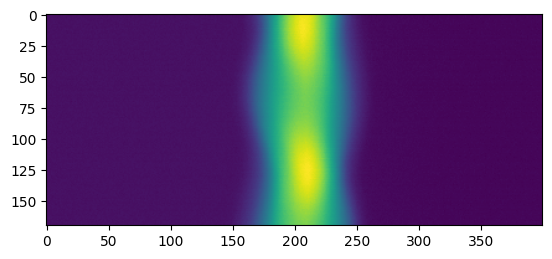

In [123]:
plt.imshow(acq_tomo['value'])
print(acq_tomo['value'].shape)

(1, 46240)
[-24998 -24970 -24972 ... -25056 -25065 -25063]


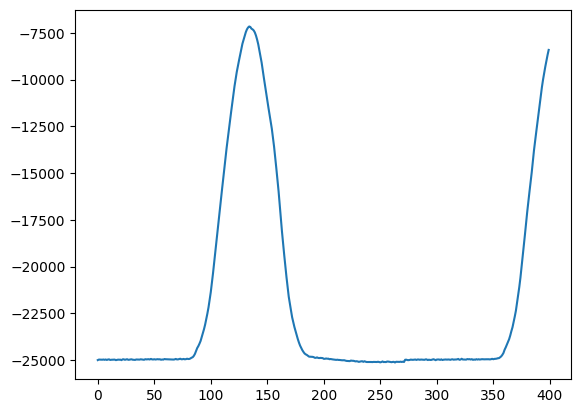

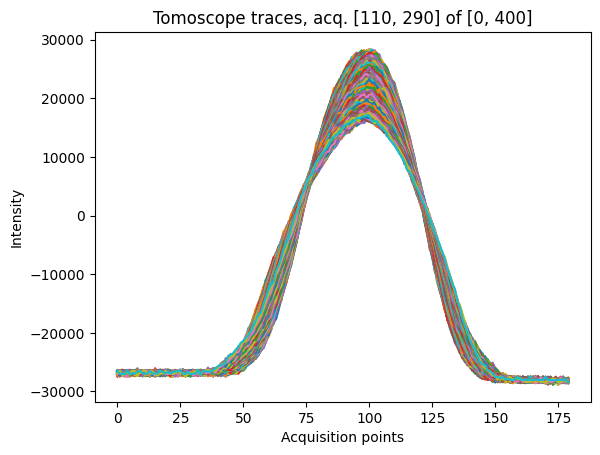

In [124]:
from scipy.signal import find_peaks


print(acq_lbo.get('bunchData').shape)
arr = acq_lbo.get('bunchData')[0]
print(arr)

plt.plot(np.arange(400), arr[:400])
plt.show()


num_traces = acq_tomo['value'].shape[0]

start = 110
end = 290
cut_width = end-start
acq_width = acq_tomo['value'].shape[1]
for i in range(num_traces):
    plt.plot(np.arange(cut_width), acq_tomo['value'][i,start:end])
plt.xlabel("Acquisition points")
plt.ylabel("Intensity")
plt.title("Tomoscope traces, acq. [" + str(start) + ", " + str(end) + "] of [0, " + str(acq_width) + "]")
plt.show()

In [125]:
def set_params(acq_tomo, acq_lbo):
    # tomography parameters (from lbo)
    dtbin: float = acq_lbo.get("dtBin")
    vrf1: float = acq_lbo.get("vrf1") #143992.95 : to old tomo's 144927.76 makes no difference
    vrf2: float = acq_lbo.get("vrf2") #0 (same as old tomo)
    h_num: int = acq_lbo.get("hNum")
    n_bins: int = acq_lbo.get("nBins") #272
    b: float = acq_lbo.get("b") #.15533596 : to old tomo's .143996 makes no difference
    bdot: float =  acq_lbo.get("bDot") #0.007206 : to old tomo's .789 makes no difference
    n_profs: int = acq_lbo.get("nProfs")
    snpt: int = acq_lbo.get("snpt") #2 : to old tomo's 4 makes no difference
    rebin: int = acq_lbo.get("rebin")
    niter: int = acq_lbo.get("nIter") #25 (same)
    dturns: int = acq_lbo.get("dTurns")
    burst_number: int = acq_lbo.get("burstNumber")
    charge: int = acq_lbo.get("charge")
    rest_mass: float = acq_lbo.get("restMass")
    vrf1_dot: float = acq_lbo.get("vrf1Dot") #0 (same)
    vrf2_dot: float =acq_lbo.get("vrf2Dot") #0 (same)
    h_ratio: float = acq_lbo.get("hRatio") #1 (same)

    # Machine Params
    radius: float = acq_lbo.get("radius")
    radius_bending: float = acq_lbo.get("radiusBending")
    output_dir: str = acq_lbo.get("outputDir")
    demax: int = acq_lbo.get("demax")
    film_start: int = acq_lbo.get("filmStart")
    film_stop: int = acq_lbo.get("filmStop")
    film_step: int = acq_lbo.get("filmStep")
    full_pp_flag: bool = acq_lbo.get("fullPPFlag")
    gamma_tr: float = acq_lbo.get("gammaTr")
    beam_ref_frame: int = acq_lbo.get("beamRefFrame")
    machine_ref_frame: int = acq_lbo.get("machineRefFrame")
    phi12: float = acq_lbo.get("phi12")
    field_flag: bool = acq_lbo.get("fieldFlag")
    g_coupling: float = acq_lbo.get("gCoupling")
    zwall_over_n: float = acq_lbo.get("zwallOverN")
    pickup_sensitivity: float = acq_lbo.get("pickupSensitivity")
    min_dt: float = acq_lbo.get("minDt")

    # set param values
    params = TomoParams(
        dtbin,
        vrf1,
        vrf2,
        h_num,
        n_bins,
        b,
        bdot,
        n_profs,
        snpt,
        rebin,
        niter,
        dturns,
        burst_number,
        charge,
        rest_mass,
        vrf1_dot,
        vrf2_dot,
        h_ratio,
    )
    machine_params = MachineParams(
            RADIUS=radius,
            RADIUS_BENDING=radius_bending,
            GAMMA_T=gamma_tr,
            OUTPUT_DIR=output_dir,
            DEMAX=demax,
            FILM_START=film_start,
            FILM_STOP=film_stop,
            FILM_STEP=film_step,
            FULL_PP_FLAG=full_pp_flag,
            BEAM_REF_FRAME=beam_ref_frame,
            MACHINE_REF_FRAME=machine_ref_frame,
            PHI12=phi12,
            SELF_FIELD_FLAG=field_flag,
            G_COUPLING=g_coupling,
            ZWALL_OVER_N=zwall_over_n,
            PICKUP_SENSITIVITY=pickup_sensitivity,
            MIN_DT=min_dt,
        )

    return params, machine_params, n_profs, n_bins, dtbin, rebin

import scipy.signal as signal

def inverse_high_pass_inductive_filter(signal_in, time_constant_tau, sampling_rate):
    """
    Simulates the inverse effect of a parallel RLC circuit (with C=0) high-pass filter,
    thereby correcting its influence. This acts as a low-pass filter.

    Args:
        signal_in (numpy.ndarray): Input signal.
        inductance (float): Inductance value (in Henries).
        resistance (float): Resistance value (in Ohms).
        sampling_rate (float): Sampling rate of the signal (in Hz).

    Returns:
        tuple: (corrected_signal, b_coefficients, a_coefficients)
    """
    if time_constant_tau == 0:
        return signal_in, [1], [1]

    #     time_constant_tau = inductance / resistance # L/R for this specific high-pass case
    K = 2 * time_constant_tau * sampling_rate

    # The inverse filter will swap the roles of b and a coefficients (roughly)
    # The original H(z) = N(z)/D(z), inverse is D(z)/N(z)
    # b_inverse = a_original, a_inverse = b_original (with normalization)

    # Original a_original = [1, (1 - K) / (1 + K)]
    b_inv = [1, (1 - K) / (1 + K)]

    # Original b_original = [K / (1 + K), -K / (1 + K)]
    # We need to normalize a_inv[0] to 1, so divide by a_original_b[0] = K/(1+K)
    a_inv_norm_factor = K / (1 + K)
    a_inv = [1, -1]  # Coefficients after dividing by the normalization factor (K/(1+K))

    signal_out = signal.lfilter(b_inv, a_inv, signal_in)
    return signal_out, b_inv, a_inv


# burst 7 has 16 bunches
def get_tomo_bunches(acq_tomo, n_bins, dtbin):
    # goal is to produce a [16,length] array, sorting per bunch like LBO
    # have an [80, 2000] array of profiles
    # does the same bunch appear multiple times in a long enough profile? yes! if over 2.1 microseconds
    # ns/pt the same for both? .5 for LBO, only do first 8 on 2000 samples for old
    # how to make sure that delay is aligned such that first bunches are same? can't actually, have permutation invar
    # to stitch bunches together? do max+- nbins/2, imported from lbo, for each bunch

    num_bunches = 1
    
    tomo_dict = dict()
    for i in range(num_bunches):
        tomo_dict[str(i)] = np.array([])
    data = acq_tomo['value']

    inductance = 10e-6  # Henries
    resistance = 6  # Ohms
    time_constant_tau = inductance / resistance

    data_corr_array = [] 
    for trace in data:
        corr_trace = inverse_high_pass_inductive_filter(
            trace.astype(np.int32),
            time_constant_tau,
            1 / (1e-9 * 1),
        )[0]
        corr_trace = corr_trace - np.arange(len(trace)) / len(trace) * (
            corr_trace[-1] - corr_trace[0]
        )
        corr_trace = corr_trace - corr_trace[0] - 25000
        data_corr_array.append(corr_trace)
    data = np.array(data_corr_array)

    pks = []
    for trace in data:
        if (len(pks) == 0):
            pks, _ = find_peaks(trace, distance = 20000, width=20)
            pks = np.array(pks)
        else:
            pks_trace, _ = find_peaks(trace, distance = 20000, width=20)
            pks = pks + np.array(pks_trace)
            
    pks = pks/len(data[:,0])   

    shift = 0
    
    for i in range(len(data[:,0])):
        arr = data[i,:]
        
        for j, peak in enumerate(pks):
            bunch = arr[int(peak-(n_bins/2)) + shift :int(peak+(n_bins/2)) + shift]
            tomo_dict[str(j)] = np.concatenate([tomo_dict[str(j)], bunch])

    tomo_bunches = []

    for i in range(num_bunches):
        tomo_bunches.append(tomo_dict[str(i)])

    for i, arr in enumerate(tomo_bunches):
        print(f"Bunch {i} length: {len(arr)}")
    
    return np.array(tomo_bunches)


In [126]:
def tomo_lbo_compare(acq_tomo, acq_lbo):
    
    # initializing
    cycle_burst_folder_path = acq_lbo.get("cycleBurstFolderPath")
    max_dist = acq_lbo.get("maxCut")
    tomo_recon_tr = 1

    # get lbo bunch data
    list_lbo_bunches = np.atleast_2d(acq_lbo.get("bunchData"))

    # set param values
    params, machine_params, n_profs, n_bins, dtbin, rebin = set_params(acq_tomo, acq_lbo)

    # get tomo bunch data
    list_tomo_bunches = get_tomo_bunches(acq_tomo, n_bins, dtbin)

    # normalize bunch data
    for i in range(len(list_lbo_bunches)):
        lbo_bunch = list_lbo_bunches[i]
        
        lbo_max = np.max(lbo_bunch)
        lbo_min = np.min(lbo_bunch)
        lbo_bunch = (lbo_bunch-lbo_min)/(lbo_max-lbo_min)
        
        plt.imshow(lbo_bunch.reshape((n_profs, n_bins)), origin="lower", aspect="auto") #old tomo
        plt.title("LBO Real Waterfall (Normalized)")
        plt.xlabel("Acq. pts")
        plt.ylabel("Trace #")
        plt.show()
        
        tomo_bunch = list_tomo_bunches[i]
        
        tomo_max = np.max(tomo_bunch)
        tomo_min = np.min(tomo_bunch)
        tomo_bunch = (tomo_bunch-tomo_min)/(tomo_max-tomo_min)

        plt.imshow(tomo_bunch.reshape((n_profs, n_bins)), origin="lower", aspect="auto") #old tomo
        plt.title("Tomo Real Waterfall (Normalized)")
        plt.xlabel("Acq. pts")
        plt.ylabel("Trace #")
        plt.show()

        plt.imshow(lbo_bunch.reshape((n_profs, n_bins)) - tomo_bunch.reshape((n_profs, n_bins)),  vmin=0, vmax=.1, origin="lower", aspect="auto")
        plt.title("LBO - Tomo Real Waterfall (Normalized)")
        plt.xlabel("Acq. pts")
        plt.ylabel("Trace #")
        plt.show()
    
    # tracking results for initial
    raw_tomo_params: dict = load_json(f"/nfs/cs-513-atomops{cycle_burst_folder_path}/raw_params.json")
    
    # lbo tracking
    xs: np.ndarray = np.load(f"/nfs/cs-513-atomops{cycle_burst_folder_path}/xs.npy", allow_pickle=True)
    ys: np.ndarray = np.load(f"/nfs/cs-513-atomops{cycle_burst_folder_path}/ys.npy", allow_pickle=True)
    with open(f"/nfs/cs-513-atomops{cycle_burst_folder_path}/machine.pkl", "rb") as f:
        machine: Machine = pickle.load(f)

    # lbo reconstruction

    lbo_tomo_phase_space_per_bunch_t: List[np.ndarray] = list()
    lbo_tomo_phase_space_per_bunch_e: List[np.ndarray] = list()
    lbo_tomo_phase_space_per_bunch_ps: List[np.ndarray] = list()
    lbo_profiles_time_meas_list: List[np.ndarray] = list()
    lbo_profiles_time_recon_list: List[np.ndarray] = list()
    lbo_profiles_e_recon_list: List[np.ndarray] = list()
    lbo_tomo_emmitances = list()
    lbo_missing_bunches = list()
    lbo_loss_func_list = list()
    lbo_recreated_wf_list = list()

    ps= PhaseSpace.from_machine(machine, turn=tomo_recon_tr)
    sep_phi, sep_de = ps.hamiltonian_contour(ps.u_ref_u)
    sep_phi = ps.p2t(sep_phi)

    partial_do_back_projection_on_bunch = partial(
        do_back_projection_on_bunch,
        n_profs=n_profs,
        n_bins=n_bins,
        params=params,
        xs=xs,
        ys=ys,
        data_json=raw_tomo_params,
        dtbin=dtbin,
        rebin=rebin,
        machine=machine,
        reconstr_idx=tomo_recon_tr,
    )

    for idx, bunch in enumerate(list_lbo_bunches):
        bunch = bunch.reshape((n_profs, n_bins))
        (
            success,
            exception,
            t,
            e,
            phase_data,
            tomographics,
            profiles,
            loss_func,
            recreated_wf,
        ) = partial_do_back_projection_on_bunch(bunch)
        if success:
            lbo_tomo_phase_space_per_bunch_t.append(t)
            lbo_tomo_phase_space_per_bunch_e.append(e)
            lbo_tomo_phase_space_per_bunch_ps.append(phase_data)
            lbo_profiles_time_meas_list.append(profiles["meas_profile_time"])
            lbo_profiles_time_recon_list.append(profiles["recon_profile_time"])
            lbo_profiles_e_recon_list.append(profiles["recon_profile_de"])
            lbo_tomo_emmitances.append(tomographics)
            lbo_loss_func_list.append(loss_func)
            lbo_recreated_wf_list.append(recreated_wf.flatten())
        else:
            lbo_tomo_exception = "back projection: " + str(exception)
            print(exception)
            lbo_missing_bunches.append(idx)

    lbo_emitt_rms_list = np.atleast_1d([i["emittRms"] for i in lbo_tomo_emmitances]).astype(
        np.float64
    )
    lbo_emitt_90_list = np.atleast_1d(
        [i["emitt90Perc"] for i in lbo_tomo_emmitances]
    ).astype(np.float64)
    lbo_matched_area_list = np.atleast_1d(
        [i["mtchdArea"] for i in lbo_tomo_emmitances]
    ).astype(np.float64)
    lbo_dp_p_list = np.atleast_1d([i["dpOverPRms"] for i in lbo_tomo_emmitances]).astype(
        np.float64
    )
    lbo_duration_list = np.atleast_1d([i["duration"] for i in lbo_tomo_emmitances]).astype(
        np.float64
    )

    # tomo reconstruction

    tomo_tomo_phase_space_per_bunch_t: List[np.ndarray] = list()
    tomo_tomo_phase_space_per_bunch_e: List[np.ndarray] = list()
    tomo_tomo_phase_space_per_bunch_ps: List[np.ndarray] = list()
    tomo_profiles_time_meas_list: List[np.ndarray] = list()
    tomo_profiles_time_recon_list: List[np.ndarray] = list()
    tomo_profiles_e_recon_list: List[np.ndarray] = list()
    tomo_tomo_emmitances = list()
    tomo_missing_bunches = list()
    tomo_loss_func_list = list()
    tomo_recreated_wf_list = list()
    
    ps = PhaseSpace.from_machine(machine, turn=tomo_recon_tr)
    sep_phi, sep_de = ps.hamiltonian_contour(ps.u_ref_u)
    sep_phi = ps.p2t(sep_phi)

    partial_do_back_projection_on_bunch = partial(
        do_back_projection_on_bunch,
        n_profs=n_profs,
        n_bins=n_bins,
        params=params,
        xs=xs,
        ys=ys,
        data_json=raw_tomo_params,
        dtbin=dtbin,
        rebin=rebin,
        machine=machine,
        reconstr_idx=tomo_recon_tr,
    )

    for idx, bunch in enumerate(list_tomo_bunches):
        bunch = bunch.reshape((n_profs, n_bins))
        (
            success,
            exception,
            t,
            e,
            phase_data,
            tomographics,
            profiles,
            loss_func,
            recreated_wf,
        ) = partial_do_back_projection_on_bunch(bunch)
        if success:
            tomo_tomo_phase_space_per_bunch_t.append(t)
            tomo_tomo_phase_space_per_bunch_e.append(e)
            tomo_tomo_phase_space_per_bunch_ps.append(phase_data)
            tomo_profiles_time_meas_list.append(profiles["meas_profile_time"])
            tomo_profiles_time_recon_list.append(profiles["recon_profile_time"])
            tomo_profiles_e_recon_list.append(profiles["recon_profile_de"])
            tomo_tomo_emmitances.append(tomographics)
            tomo_loss_func_list.append(loss_func)
            tomo_recreated_wf_list.append(recreated_wf.flatten())
        else:
            tomo_tomo_exception = "back projection: " + str(exception)
            print(exception)
            tomo_missing_bunches.append(idx)


    print(tomo_missing_bunches)
    tomo_emitt_rms_list = np.atleast_1d([i["emittRms"] for i in tomo_tomo_emmitances]).astype(
        np.float64
    )
    tomo_emitt_90_list = np.atleast_1d(
        [i["emitt90Perc"] for i in tomo_tomo_emmitances]
    ).astype(np.float64)
    tomo_matched_area_list = np.atleast_1d(
        [i["mtchdArea"] for i in tomo_tomo_emmitances]
    ).astype(np.float64)
    tomo_dp_p_list = np.atleast_1d([i["dpOverPRms"] for i in tomo_tomo_emmitances]).astype(
        np.float64
    )
    tomo_duration_list = np.atleast_1d([i["duration"] for i in tomo_tomo_emmitances]).astype(
        np.float64
    )

    print("LBO and Tomo observables (mean and standard deviation) :")
    print('\n')
    print("LBO RMS EMITTENCE: " + str(np.mean(lbo_emitt_rms_list)) + " +- " + str(np.std(lbo_emitt_rms_list)))
    print("TOMO RMS EMITTENCE: " + str(np.mean(tomo_emitt_rms_list)) + " +- " + str(np.std(tomo_emitt_rms_list)))
    print('\n')
    print("LBO 90% EMITTENCE: " + str(np.mean(lbo_emitt_90_list)) + " +- " + str(np.std(lbo_emitt_90_list)))
    print("TOMO 90% EMITTENCE: " + str(np.mean(tomo_emitt_90_list)) + " +- " + str(np.std(tomo_emitt_90_list)))
    print('\n')
    print("LBO MATCHED AREA: " + str(np.mean(lbo_matched_area_list)) + " +- " + str(np.std(lbo_matched_area_list)))
    print("TOMO MATCHED AREA: " + str(np.mean(tomo_matched_area_list)) + " +- " + str(np.std(tomo_matched_area_list)))
    print('\n')
    print("LBO DP/P: " + str(np.mean(lbo_dp_p_list)) + " +- " + str(np.std(lbo_dp_p_list)))
    print("TOMO DP/P: " + str(np.mean(tomo_dp_p_list)) + " +- " + str(np.std(tomo_dp_p_list)))
    print('\n')
    print("LBO DURATION: " + str(np.mean(lbo_duration_list)) + " +- " + str(np.std(lbo_duration_list)))
    print("TOMO DURATION: " + str(np.mean(tomo_duration_list)) + " +- " + str(np.std(tomo_duration_list)))
    print('\n')

    for i in range(len(lbo_profiles_time_recon_list)):
        meas = lbo_profiles_time_meas_list[i]
        recon = lbo_profiles_time_recon_list[i]
        loss = lbo_loss_func_list[i]
        

        fig = plt.figure(figsize=(15,7))
        fig.suptitle("LBO")
        # tomo phase space
        ax1 = fig.add_subplot(1,2,1)
        ax1.plot(np.arange(len(meas)), meas, label = "measured")
        ax1.plot(np.arange(len(recon)), recon, label = "reconstructed")
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Norm. units")
        ax1.set_title("Phase projection")
        ax1.legend()

        ax2 = fig.add_subplot(1,2,2)
        ax2.plot(np.arange(len(loss)), loss)
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Loss")
        ax2.set_title("Loss function")

        plt.show()
        
        
    for i in range(len(tomo_profiles_time_recon_list)):
        meas = tomo_profiles_time_meas_list[i]
        recon = tomo_profiles_time_recon_list[i]
        loss = tomo_loss_func_list[i]
        

        fig = plt.figure(figsize=(15,7))
        fig.suptitle("Tomo")
        # tomo phase space
        ax1 = fig.add_subplot(1,2,1)
        ax1.plot(np.arange(len(meas)), meas, label = "measured")
        ax1.plot(np.arange(len(recon)), recon, label = "reconstructed")
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Norm. units")
        ax1.set_title("Phase projection")
        ax1.legend()

        ax2 = fig.add_subplot(1,2,2)
        ax2.plot(np.arange(len(loss)), loss)
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Loss")
        ax2.set_title("Loss function")

        plt.show()
        
    for idx, _ in enumerate(lbo_tomo_phase_space_per_bunch_ps):
        plt.figure()
        plt.title(f"LBO - 90% emmit: {lbo_emitt_90_list[idx]:.2f} eVs, RMS emmit: {lbo_emitt_rms_list[idx]:.2f} eVs, Matched emmit: {lbo_matched_area_list[idx]:.2f} eVs, dpp: {1e3*lbo_dp_p_list[idx]:.2f} E-3")
        plt.imshow(
            lbo_tomo_phase_space_per_bunch_ps[idx].T, 
            extent=[
                lbo_tomo_phase_space_per_bunch_t[idx][0], 
                lbo_tomo_phase_space_per_bunch_t[idx][-1], 
                lbo_tomo_phase_space_per_bunch_e[idx][0], 
                lbo_tomo_phase_space_per_bunch_e[idx][-1]
            ],
            origin="lower",
            aspect="auto",
            cmap="RdYlBu_r"
        )
        plt.plot(sep_phi, sep_de)
        plt.axvline(0, ls="--", c = "grey")
        plt.axhline(0, ls="--", c = "grey")
        plt.show()
    
    for idx, _ in enumerate(tomo_tomo_phase_space_per_bunch_ps):
        plt.figure()
        plt.title(f"Tomo - 90% emmit: {tomo_emitt_90_list[idx]:.2f} eVs, RMS emmit: {tomo_emitt_rms_list[idx]:.2f} eVs, Matched emmit: {tomo_matched_area_list[idx]:.2f} eVs, dpp: {1e3*tomo_dp_p_list[idx]:.2f} E-3")
        plt.imshow(
            tomo_tomo_phase_space_per_bunch_ps[idx].T, 
            extent=[
                tomo_tomo_phase_space_per_bunch_t[idx][0], 
                tomo_tomo_phase_space_per_bunch_t[idx][-1], 
                tomo_tomo_phase_space_per_bunch_e[idx][0], 
                tomo_tomo_phase_space_per_bunch_e[idx][-1]
            ],
            origin="lower",
            aspect="auto",
            cmap="RdYlBu_r"
        )
        plt.plot(sep_phi, sep_de)
        plt.axvline(0, ls="--", c = "grey")
        plt.axhline(0, ls="--", c = "grey")
        plt.show()
    


Bunch 0 length: 46240


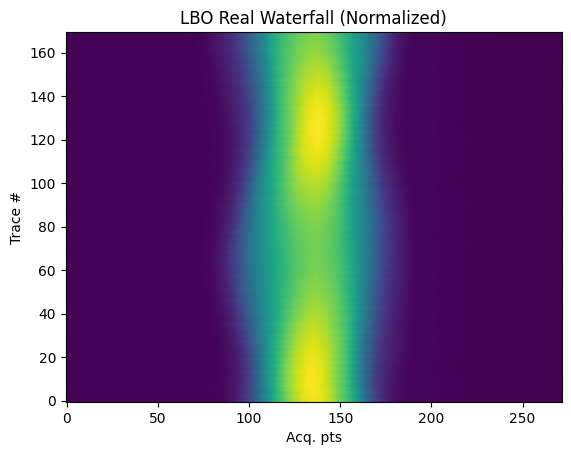

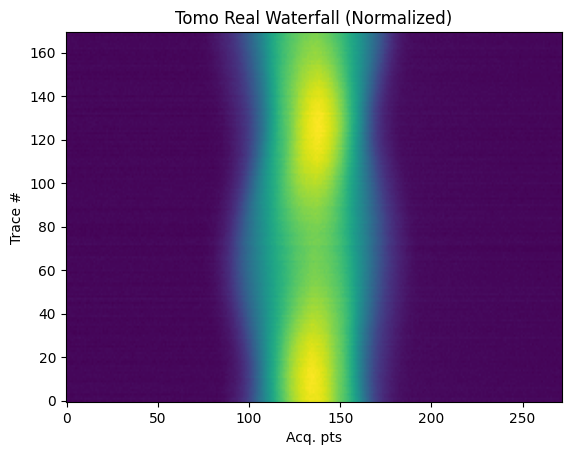

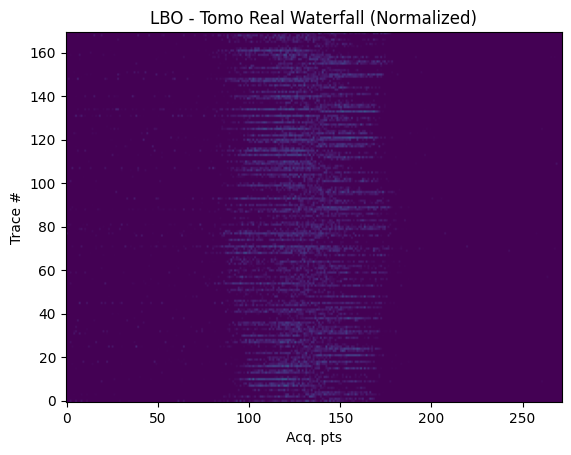

/opt/home/loshaugh/tomolbo_analysis/.venv/lib/python3.11/site-packages/cps_bcwlbo_ucap/tomography_converters/helpers/phase_space.py:227: RuntimeWarning: invalid value encountered in sqrt
  de = np.sqrt((level - u) / scale)
/opt/home/loshaugh/tomolbo_analysis/.venv/lib/python3.11/site-packages/cps_bcwlbo_ucap/tomography_converters/helpers/tomographics.py:274: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(


[]
LBO and Tomo observables (mean and standard deviation) :


LBO RMS EMITTENCE: 0.41473681240807314 +- 0.0
TOMO RMS EMITTENCE: 0.4010058892549427 +- 0.0


LBO 90% EMITTENCE: 1.7053969670451952 +- 0.0
TOMO 90% EMITTENCE: 1.652518764647173 +- 0.0


LBO MATCHED AREA: 1.995789488180619 +- 0.0
TOMO MATCHED AREA: 2.019694403451647 +- 0.0


LBO DP/P: 0.0021431460437996014 +- 0.0
TOMO DP/P: 0.002116123568490427 +- 0.0


LBO DURATION: 92.86817160063991 +- 0.0
TOMO DURATION: 93.45977024782913 +- 0.0




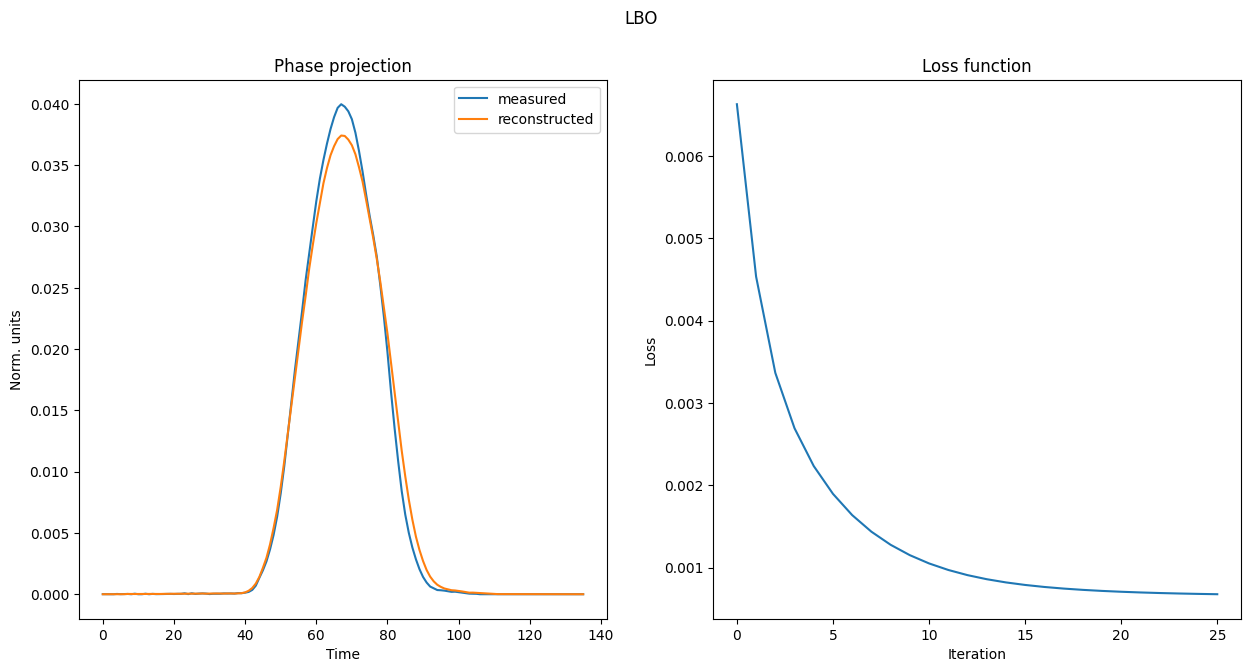

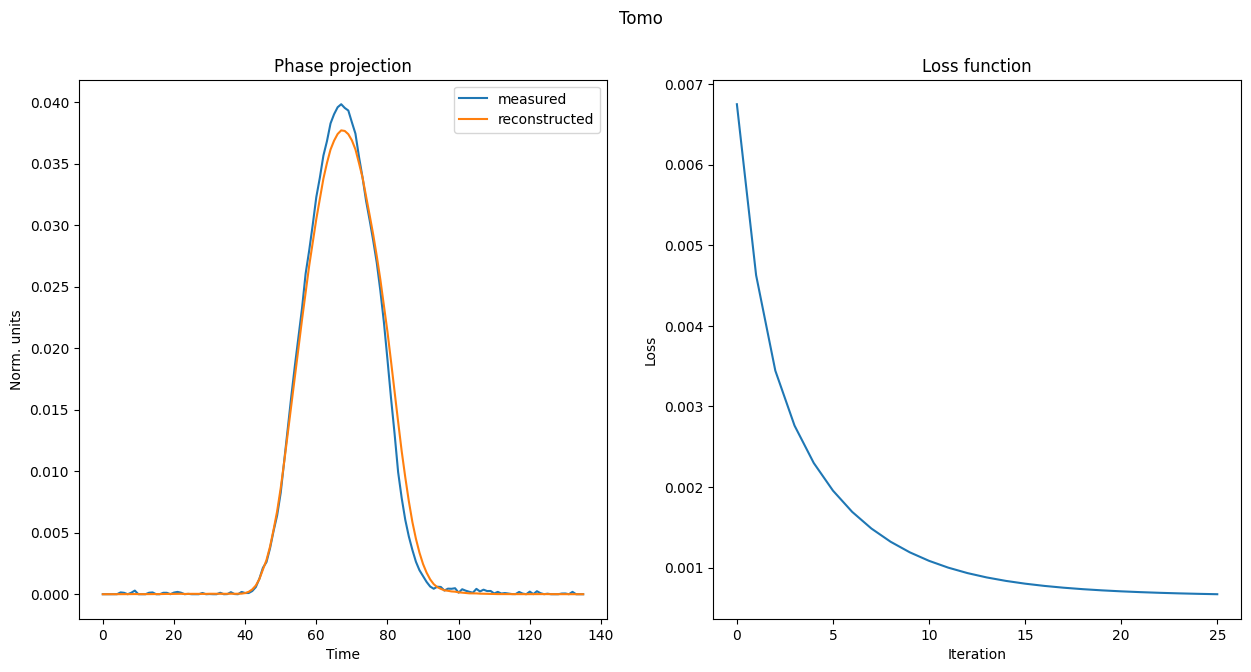

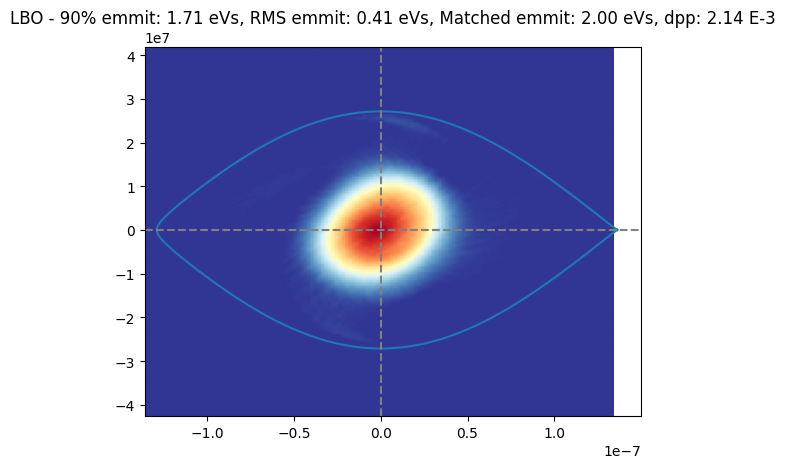

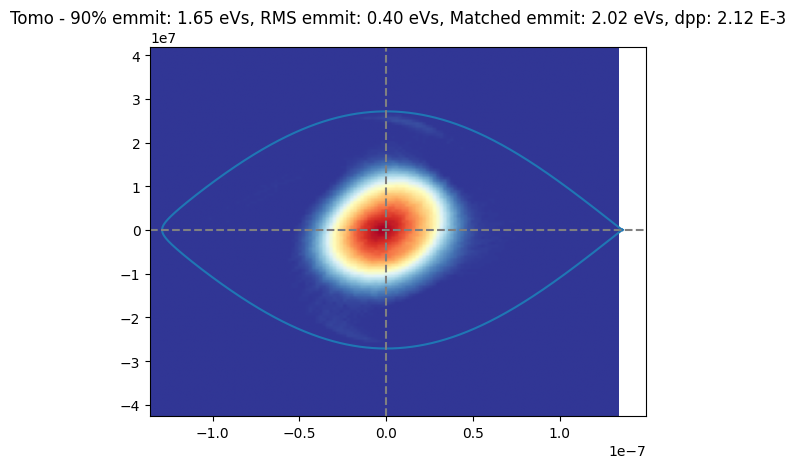

In [127]:
tomo_lbo_compare(acq_tomo, acq_lbo)

In [57]:
# burst 7 and 13 for SFTPRO1

def get_tomo_lbo_plots(acq_tomo, acq_lbo):


    cycle_burst_folder_path = acq_lbo.get("cycleBurstFolderPath")
    list_bunches = np.atleast_2d(acq_lbo.get("bunchData"))
    max_dist = acq_lbo.get("maxCut")
    
    tomo_recon_tr = 80

    # set param values
    params, machine_params, n_profs, n_bins, dtbin = set_params(acq_tomo, acq_lbo)

    # process first bunch data from lbo (can get this straight from old tomo)
    list_bunches_lbo: np.ndarray = acq_lbo.get("bunchData")
    first_bunch = list_bunches_lbo[0].reshape((n_profs, n_bins))

    # how to break old tomo bunch by bunch?
    
    #print( acq_tomo["value"][:,64:-64] - first_bunch)
    #print("max: " + str(np.max(acq_tomo["value"][:,64:-64] - first_bunch)))

    # crop and align tomo
    crop = 64
    shift = 2
    tomo_bunch = acq_tomo["value"][:,(crop+shift):(-crop+shift)].astype(np.int32)

    # transfer function correction for tomo
    burst_data_list = list()
    inductance = 10e-6  # Henries
    resistance = 6  # Ohms
    time_constant_tau = inductance / resistance
    for trace in tomo_bunch:
        corr_trace = inverse_high_pass_inductive_filter(
            trace.astype(np.int32),
            time_constant_tau,
            1 / (dtbin),
         )[0]
        corr_trace = corr_trace - np.arange(len(trace)) / len(trace) * (
             corr_trace[-1] - corr_trace[0]
         )
        corr_trace = corr_trace - corr_trace[0] - 25000
        burst_data_list.append(corr_trace)

    # normalize amplitudes to [0,1]
    tomo_bunch = np.asarray(burst_data_list)
    tomo_max = np.max(tomo_bunch)
    tomo_min = np.min(tomo_bunch)
    tomo_bunch = (tomo_bunch-tomo_min)/(tomo_max-tomo_min)
    lbo_bunch = first_bunch.astype(np.int32)
    lbo_max = np.max(lbo_bunch)
    lbo_min = np.min(lbo_bunch)
    lbo_bunch = (lbo_bunch-lbo_min)/(lbo_max-lbo_min)
    
    # plot waterfall for both
    fig = plt.figure()
    fig.suptitle("Normalized Waterfall Plots")
    # tomo waterfall
    ax1 = fig.add_subplot(1,3,1)
    im1 = ax1.imshow(tomo_bunch, origin="lower", aspect="auto") #old tomo
    ax1.set_title("Old Tomoscope")
    ax1.set_xlabel("Acq. pts")
    ax1.set_ylabel("Trace #")
    # lbo waterfall
    ax2 = fig.add_subplot(1,3,2)
    im2 = ax2.imshow(lbo_bunch, origin="lower", aspect="auto") # new lbo
    ax2.set_title("New LBO")
    ax2.set_xlabel("Acq. pts")
    ax2.set_ylabel("Trace #")
    # tomo-lbo waterfall
    ax3 = fig.add_subplot(1,3,3)
    im3 = ax3.imshow((tomo_bunch-lbo_bunch), vmin=0, vmax=.1, origin="lower", aspect="auto")
    ax3.set_title("Tomo - LBO")
    ax3.set_xlabel("Acq. pts")
    ax3.set_ylabel("Trace #")
    plt.tight_layout()
    plt.show()

    # tracking results for initial
    raw_tomo_params: dict = load_json(f"/nfs/cs-513-atomops{cycle_burst_folder_path}/raw_params.json")

    # lbo tracking
    xs: np.ndarray = np.load(f"/nfs/cs-513-atomops{cycle_burst_folder_path}/xs.npy", allow_pickle=True)
    ys: np.ndarray = np.load(f"/nfs/cs-513-atomops{cycle_burst_folder_path}/ys.npy", allow_pickle=True)
    with open(f"/nfs/cs-513-atomops{cycle_burst_folder_path}/machine.pkl", "rb") as f:
        machine: Machine = pickle.load(f)

    # lbo reconstruction

    lbo_tomo_phase_space_per_bunch_t: List[np.ndarray] = list()
    lbo_tomo_phase_space_per_bunch_e: List[np.ndarray] = list()
    lbo_tomo_phase_space_per_bunch_ps: List[np.ndarray] = list()
    lbo_profiles_time_meas_list: List[np.ndarray] = list()
    lbo_profiles_time_recon_list: List[np.ndarray] = list()
    lbo_profiles_e_recon_list: List[np.ndarray] = list()
    lbo_tomo_emmitances = list()
    lbo_missing_bunches = list()
    lbo_loss_func_list = list()
    lbo_recreated_wf_list = list()
    
    ps= PhaseSpace.from_machine(machine, turn=tomo_recon_tr)
    sep_phi, sep_de = ps.hamiltonian_contour(ps.u_ref_u)
    sep_phi = ps.p2t(sep_phi)

    partial_do_back_projection_on_bunch = partial(
        do_back_projection_on_bunch,
        n_profs=n_profs,
        n_bins=n_bins,
        params=params,
        xs=xs,
        ys=ys,
        data_json=raw_tomo_params,
        dtbin=dtbin,
        rebin=rebin,
        machine=machine,
        reconstr_idx=tomo_recon_tr,
    )

    for idx, bunch in enumerate(lbo_list_bunches):
        (
            success,
            exception,
            t,
            e,
            phase_data,
            tomographics,
            profiles,
            loss_func,
            recreated_wf,
        ) = partial_do_back_projection_on_bunch(bunch)
        if success:
            lbo_tomo_phase_space_per_bunch_t.append(t)
            lbo_tomo_phase_space_per_bunch_e.append(e)
            lbo_tomo_phase_space_per_bunch_ps.append(phase_data)
            lbo_profiles_time_meas_list.append(profiles["meas_profile_time"])
            lbo_profiles_time_recon_list.append(profiles["recon_profile_time"])
            lbo_profiles_e_recon_list.append(profiles["recon_profile_de"])
            lbo_tomo_emmitances.append(tomographics)
            lbo_loss_func_list.append(loss_func)
            lbo_recreated_wf_list.append(recreated_wf.flatten())
        else:
            lbo_tomo_exception = "back projection: " + str(exception)
            lbo_missing_bunches.append(idx)

    lbo_emitt_rms_list = np.atleast_1d([i["emittRms"] for i in lbo_tomo_emmitances]).astype(
        np.float64
    )
    lbo_emitt_90_list = np.atleast_1d(
        [i["emitt90Perc"] for i in lbo_tomo_emmitances]
    ).astype(np.float64)
    lbo_matched_area_list = np.atleast_1d(
        [i["mtchdArea"] for i in lbo_tomo_emmitances]
    ).astype(np.float64)
    lbo_dp_p_list = np.atleast_1d([i["dpOverPRms"] for i in lbo_tomo_emmitances]).astype(
        np.float64
    )
    lbo_duration_list = np.atleast_1d([i["duration"] for i in lbo_tomo_emmitances]).astype(
        np.float64
    )

    # tomo reconstruction

    tomo_tomo_phase_space_per_bunch_t: List[np.ndarray] = list()
    tomo_tomo_phase_space_per_bunch_e: List[np.ndarray] = list()
    tomo_tomo_phase_space_per_bunch_ps: List[np.ndarray] = list()
    tomo_profiles_time_meas_list: List[np.ndarray] = list()
    tomo_profiles_time_recon_list: List[np.ndarray] = list()
    lbo_profiles_e_recon_list: List[np.ndarray] = list()
    tomo_tomo_emmitances = list()
    tomo_missing_bunches = list()
    tomo_loss_func_list = list()
    tomo_recreated_wf_list = list()
    
    ps = PhaseSpace.from_machine(machine, turn=tomo_recon_tr)
    sep_phi, sep_de = ps.hamiltonian_contour(ps.u_ref_u)
    sep_phi = ps.p2t(sep_phi)

    partial_do_back_projection_on_bunch = partial(
        do_back_projection_on_bunch,
        n_profs=n_profs,
        n_bins=n_bins,
        params=params,
        xs=xs,
        ys=ys,
        data_json=raw_tomo_params,
        dtbin=dtbin,
        rebin=rebin,
        machine=machine,
        reconstr_idx=tomo_recon_tr,
    )

    for idx, bunch in enumerate(list_bunches):
        (
            success,
            exception,
            t,
            e,
            phase_data,
            tomographics,
            profiles,
            loss_func,
            recreated_wf,
        ) = partial_do_back_projection_on_bunch(bunch)
        if success:
            tomo_tomo_phase_space_per_bunch_t.append(t)
            tomo_tomo_phase_space_per_bunch_e.append(e)
            tomo_tomo_phase_space_per_bunch_ps.append(phase_data)
            tomo_profiles_time_meas_list.append(profiles["meas_profile_time"])
            tomo_profiles_time_recon_list.append(profiles["recon_profile_time"])
            tomo_profiles_e_recon_list.append(profiles["recon_profile_de"])
            tomo_tomo_emmitances.append(tomographics)
            tomo_loss_func_list.append(loss_func)
            tomo_recreated_wf_list.append(recreated_wf.flatten())
        else:
            tomo_tomo_exception = "back projection: " + str(exception)
            tomo_missing_bunches.append(idx)


    tomo_emitt_rms_list = np.atleast_1d([i["emittRms"] for i in tomo_tomo_emmitances]).astype(
        np.float64
    )
    tomo_emitt_90_list = np.atleast_1d(
        [i["emitt90Perc"] for i in tomo_tomo_emmitances]
    ).astype(np.float64)
    tomo_matched_area_list = np.atleast_1d(
        [i["mtchdArea"] for i in tomo_tomo_emmitances]
    ).astype(np.float64)
    tomo_dp_p_list = np.atleast_1d([i["dpOverPRms"] for i in tomo_tomo_emmitances]).astype(
        np.float64
    )
    tomo_duration_list = np.atleast_1d([i["duration"] for i in tomo_tomo_emmitances]).astype(
        np.float64
    )


    '''
    # plot projections

    fig = plt.figure(figsize=(15,7))
    fig.suptitle("Phase Space Projections")

    ax1 = fig.add_subplot(1,2,1)
    im1 = ax1.imshow(
    '''


    for idx, _ in enumerate(tomo_phase_space_per_bunch_ps):
        
        
        
        
        # phase space plots
        fig = plt.figure(figsize=(15,7))
        fig.suptitle("Old Tomoscope & New LBO Phase Space")

        # tomo phase space
        ax1 = fig.add_subplot(1,3,1)
        im1 = ax1.imshow(
        
        plt.figure()
        plt.title(f"90% emmit: {emitt_90_list[idx]:.2f} eVs, RMS emmit: {emitt_rms_list[idx]:.2f} eVs, Matched emmit: {matched_area_list[idx]:.2f} eVs, dpp: {1e3*dp_p_list[idx]:.2f} E-3")
        plt.imshow(
            tomo_phase_space_per_bunch_ps[idx].T, 
            extent=[
                tomo_phase_space_per_bunch_t[idx][0], 
                tomo_phase_space_per_bunch_t[idx][-1], 
                tomo_phase_space_per_bunch_e[idx][0], 
                tomo_phase_space_per_bunch_e[idx][-1]
            ],
            origin="lower",
            aspect="auto",
            cmap="jet"
        )
        plt.plot(sep_phi, sep_de)
        plt.axvline(0, ls="--", c = "grey")
        plt.axhline(0, ls="--", c = "grey")
        plt.show()


    
    

    
    fig = plt.figure(figsize=(15,7))
    fig.suptitle("Normalized Old Tomoscope & New LBO Phase Space")
    # tomo phase space
    ax1 = fig.add_subplot(1,3,1)
    im1 = ax1.imshow(phase_data_tomo.T, 
        extent=[
            t_tomo[0], 
            t_tomo[-1], 
            e_tomo[0], 
            e_tomo[-1]
        ],
        origin="lower",
        aspect="auto",
        cmap="RdYlBu_r"
    )
    ax1.plot(sep_phi, sep_de)
    ax1.axvline(0, ls="--", c = "grey")
    ax1.axhline(0, ls="--", c = "grey")
    ax1.set_title(f'90% emmit: {tomographics_tomo["emitt90Perc"]:.2f} eVs, RMS emmit: {tomographics_tomo["emittRms"]:.2f} eVs,\n Matched emmit: {tomographics_tomo["mtchdArea"]:.2f} eVs, dpp: {1e3*tomographics_tomo["dpOverPRms"]:.2f} E-3', fontsize=8)
    ax1.set_xlabel("dt")
    ax1.set_ylabel("dE")
    # lbo phase space
    ax2 = fig.add_subplot(1,3,2)
    im2 = ax2.imshow(phase_data_lbo.T, 
        extent=[
            t_lbo[0], 
            t_lbo[-1], 
            e_lbo[0], 
            e_lbo[-1]
        ],
        origin="lower",
        aspect="auto",
        cmap="RdYlBu_r"
    )
    ax2.plot(sep_phi, sep_de)
    ax2.axvline(0, ls="--", c = "grey")
    ax2.axhline(0, ls="--", c = "grey")
    ax2.set_title(f'90% emmit: {tomographics_lbo["emitt90Perc"]:.2f} eVs, RMS emmit: {tomographics_lbo["emittRms"]:.2f} eVs,\n Matched emmit: {tomographics_lbo["mtchdArea"]:.2f} eVs, dpp: {1e3*tomographics_lbo["dpOverPRms"]:.2f} E-3',fontsize=8)
    ax2.set_xlabel("dt")
    ax2.set_ylabel("dE")
    # tomo-lbo phase space
    ax3 = fig.add_subplot(1,3,3)
    im3 = ax3.imshow((phase_data_tomo.T - phase_data_lbo.T), 
        extent=[
            t_lbo[0], 
            t_lbo[-1], 
            e_lbo[0], 
            e_lbo[-1]
        ],
        origin="lower",
        aspect="auto",
        cmap="RdYlBu_r"
    )
    ax3.plot(sep_phi, sep_de)
    ax3.axvline(0, ls="--", c = "grey")
    ax3.axhline(0, ls="--", c = "grey")
    ax3.set_title("Tomo - LBO")
    ax3.set_xlabel("dt")
    ax3.set_ylabel("dE")

    plt.tight_layout()
    plt.show()


SyntaxError: '(' was never closed (3390471328.py, line 259)

[[-1944 -1644 -1643 ... -3008 -3096 -3516]
 [-1707 -1721 -1876 ... -3113 -3835 -3177]
 [-2205 -1639 -1569 ... -3390 -3444 -3595]
 ...
 [-1815 -1730 -1836 ... -3272 -3266 -3264]
 [-1789 -2038 -2143 ... -3364 -3460 -2988]
 [-2095 -1955 -1974 ... -2988 -3327 -3119]]
max: 32148


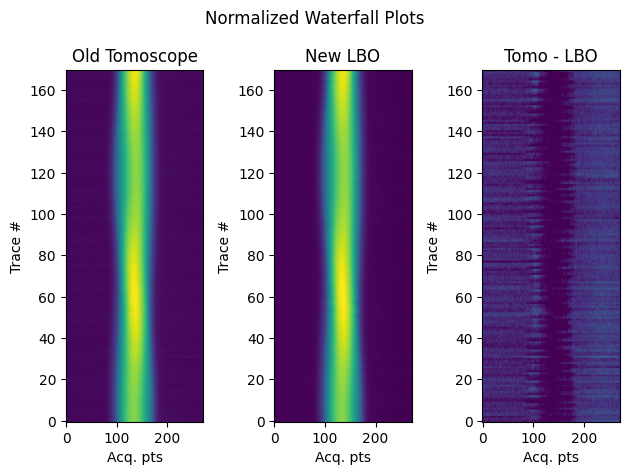

/opt/home/loshaugh/tomolbo_analysis/.venv/lib/python3.11/site-packages/cps_bcwlbo_ucap/tomography_converters/helpers/phase_space.py:227: RuntimeWarning: invalid value encountered in sqrt
  de = np.sqrt((level - u) / scale)


success_tomo: True
exception_tomo: None


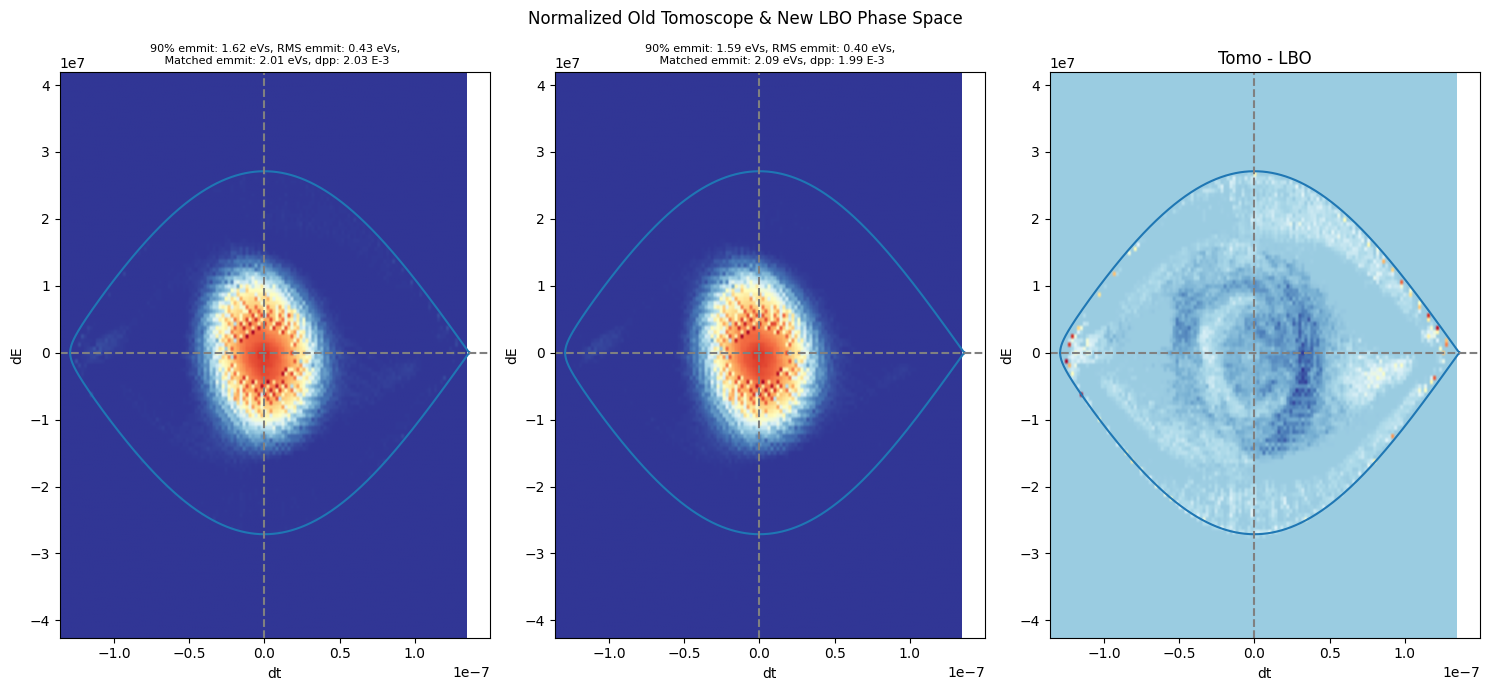

In [36]:
#original
get_tomo_lbo_plots(acq_tomo, acq_lbo)

In [24]:
get_tomo_lbo_plots(acq_tomo, acq_lbo)

ValueError: cannot reshape array of size 46240 into shape (170,400)

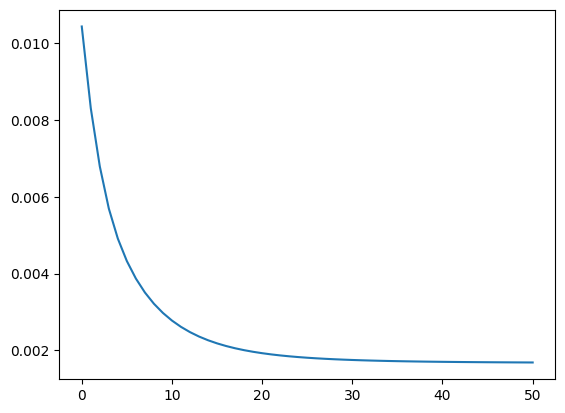

In [35]:
plt.figure()
plt.plot(loss_func_list[0])
plt.show()

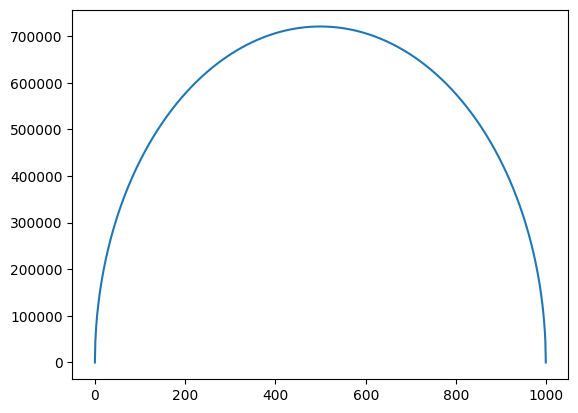

In [47]:
plt.plot(d)

In [45]:

def _urf_length_at_level(
    phi_array: Iterable[float], urf: Iterable[float], phi_0: float, urf_level: float
) -> Tuple[float, float, float]:

    urf_left = urf[phi_array < phi_0] - urf_level
    urf_right = urf[phi_array > phi_0] - urf_level
    
    # phi_left = np.interp(0, -urf_left, phi_array[phi_array < phi_0])
    phi_left = np.interp(
        0, 
        urf_left[np.argsort(urf_left)], 
        phi_array[phi_array < phi_0][np.argsort(urf_left)],
    )
    phi_right = np.interp(
        0,
        urf_right[np.argsort(urf_right)],
        phi_array[phi_array > phi_0][np.argsort(urf_right)],
    )
    phi_tot = phi_right - phi_left

    return phi_tot, phi_right, phi_left


def _residue_urf_length(
    urf_level: float, phi_target: float, phi_array: float, urf: float, phi_0: float
) -> float:

    phi_tot = _urf_length_at_level(phi_array, urf, phi_0, urf_level)[0]
    residue = (phi_tot - phi_target) ** 2.0

    return residue

NameError: name 'Iterable' is not defined

In [ ]:

# dE_height_array = np.abs(
#     np.sqrt(
#         tomomachine.q
#         * (gamma0 - 1 / gamma0)
#         * tomomachine.e_rest
#         / (np.pi * tomomachine.h_num * eta0)
#         * (
#             tomomachine.vrf1 * (np.cos(phi_array_matched) - np.cos(phi_left)) + tomomachine.vrf2 * (np.cos(tomomachine.h_ratio*(phi_array_matched-tomomachine.phi12) - np.cos(tomomachine.h_ratio*(phi_left-tomomachine.phi12)))) / tomomachine.h_ratio
#             + (phi_array_matched - phi_left) * (
#         machine.vrf1 * np.sin(phi_0)
#         + machine.vrf2
#         * np.sin(machine.h_ratio * (phi_array_matched - phi12))
#     )
#         )
#     )
# )


In [ ]:
# machine.vrf1 * (np.cos(phi_array_matched) - np.cos(phi_left)) 

In [ ]:
# plt.plot(machine.vrf1 * (np.cos(phi_array) - np.cos(phi_left)), c="b")
# plt.plot(machine.vrf2 * (np.cos(machine.h_ratio*(phi_left-phi12)) - np.cos(machine.h_ratio*(phi_array-phi12))) / machine.h_ratio, c="r")
# plt.plot((phi_array - phi_left) * (machine.vrf1 * np.sin(phi_0) + machine.vrf2 * np.sin(machine.h_ratio * (phi_array - phi12))),  c="g")

In [ ]:
machine.phi0

In [ ]:
machine.phi12

In [ ]:
phi_0 = machine.phi0[tomo_recon_tr]
energy = machine.e0[tomo_recon_tr]
eta0 = machine.eta0[tomo_recon_tr]
omega_rev0 = machine.omega_rev0[tomo_recon_tr]

bunch_length = 230*1e-9

gamma0 = energy / machine.e_rest
bunch_length_phase = bunch_length * omega_rev0 * machine.h_num

phi_array = phi_0 + np.linspace(-np.pi, np.pi, 1000)

# phi12 = np.pi/2
phi12 = machine.phi12

machine_array_rf1 = machine.vrf1 * (np.cos(phi_0) - np.cos(phi_array))
machine_array_rf2 = machine.vrf2 * (np.cos(machine.h_ratio * (phi_0 - phi12)) - np.cos(machine.h_ratio * (phi_array - phi12))) / machine.h_ratio
urf = (
    machine_array_rf1 + machine_array_rf2 + (phi_0 - phi_array)
    * (
        machine.vrf1 * np.sin(phi_0)
        + machine.vrf2
        * np.sin(machine.h_ratio * (phi_0 - phi12))
    )
)


urf_level_opti = minimize(
    _residue_urf_length,
    (np.max(urf) - np.min(urf)) / 2 + np.min(urf),
    args=(bunch_length_phase, phi_array, urf, phi_0),
    method="Nelder-Mead",
)["x"]
phi_tot, phi_right, phi_left = _urf_length_at_level(
    phi_array, urf, phi_0, urf_level_opti
)

print("phases", bunch_length_phase, phi_tot, phi_right, phi_left)

phi_array_matched = np.linspace(phi_left, phi_right, 1000)

# dE_height_array = np.abs(
#         np.sqrt(tomomachine.q* (gamma0 - 1 / gamma0)* tomomachine.e_rest/ (np.pi * tomomachine.h_num * eta0)
#             * (
#                 tomomachine.vrf1 * (np.cos(phi_array_matched) - np.cos(phi_left))
#                 + (phi_array_matched - phi_left) * tomomachine.vrf1 * np.sin(phi_0)
#             )
#         )
#     )

#     dE_height_array[np.isnan(dE_height_array)] = 0

# # Juan PHD thesis page 12 (CERN-THESIS-2016-066)
# H_sep = (
#     machine.vrf1 * (np.cos(phi_0) - np.cos(phi_left))
#     + machine.vrf2
#     * (
#         np.cos(machine.h_ratio * (phi_0 - phi12))
#         - np.cos(machine.h_ratio * (phi_left - phi12))
#     )
#     / machine.h_ratio
#     + (phi_0 - phi_left)
#     * (
#         machine.vrf1 * np.sin(phi_0)
#         + machine.vrf2
#         * np.sin(machine.h_ratio * (phi_left - phi12))
#     )
# )

urf_matched = (
    machine.vrf1 * (np.cos(phi_0) - np.cos(phi_array_matched))
    + machine.vrf2
    * (
        np.cos(machine.h_ratio * (phi_0 - phi12))
        - np.cos(machine.h_ratio * (phi_array_matched - phi12))
    )
    / machine.h_ratio
    + (phi_0 - phi_array_matched)
    * (
        machine.vrf1 * np.sin(phi_0)
        + machine.vrf2
        * np.sin(machine.h_ratio * (phi_0 - phi12))
    )
)
# print(H_sep)

# dE_height_array = np.abs(
#     np.sqrt(
#         machine.q * (gamma0 - 1 / gamma0) * machine.e_rest / (np.pi * machine.h_num * eta0)
#         * (H_sep - urf_matched)
#     )
# )

dE_height_array = np.abs(
    np.sqrt(
        machine.q * (gamma0 - 1 / gamma0) * machine.e_rest / (np.pi * machine.h_num * eta0)
        * (
            machine.vrf1 * (np.cos(phi_array_matched) - np.cos(phi_left)) 
            + machine.vrf2 * (np.cos(machine.h_ratio*(phi_array_matched-phi12)) - np.cos(machine.h_ratio*(phi_left-phi12))) / machine.h_ratio
            + (phi_array_matched - phi_left) * (machine.vrf1 * np.sin(phi_0) + machine.vrf2 * np.sin(machine.h_ratio * (phi_0 - phi12)))
        )
    )
)

dE_height_array[np.isnan(dE_height_array)] = 0

plt.figure()
plt.clf()
plt.plot(phi_array_matched, dE_height_array)

dE_traj_test = np.abs(np.sqrt(machine.q
        * (gamma0 - 1 / gamma0)
        * machine.e_rest
        / (np.pi * machine.h_num * eta0)
        * (np.max(urf_matched)-urf_matched)))


plt.plot(phi_array_matched, dE_traj_test)




plt.figure()
plt.clf()
plt.plot(phi_array, urf)
plt.plot(phi_array_matched, urf_matched)
plt.axvline(phi_left)
plt.axvline(phi_right)


matched_area = (
    2
    / (machine.h_num * omega_rev0)
    * np.trapz(dE_height_array, dx=phi_array_matched[1] - phi_array_matched[0])
)

print(matched_area)



In [ ]:
# %pip install git+https://gitlab.cern.ch/rf-br/solfege.git

In [ ]:
from solfege.parameters import (
    AcceleratorParameters,
    BeamParameters,
    RFParameters,
)
from solfege.potential import (
    get_all_rf_buckets,
    make_time_array,
)
from scipy.constants import c,e

In [ ]:


# Numerical parameters
n_points_potential = 1000
margin_percent = 5



### Building objects and get RF buckets

accelerator_parameters = AcceleratorParameters(
    BeamParameters(machine.e_rest/c**2*e, machine.q),
    machine.b0,
    0,
    machine.mean_orbit_rad*2*np.pi,
    machine.bending_rad,
    machine.trans_gamma,
)

rf_parameters = RFParameters(
    [machine.vrf1, machine.vrf2],
    [machine.h_num, machine.h_num*machine.h_ratio],
    [0, machine.phi12*machine.h_ratio],
)

main_t_rf = accelerator_parameters.t_rev / machine.h_num

time_array = make_time_array(
    -main_t_rf / 2,
    main_t_rf / 2,
    n_points_potential,
    margin_percent,
)

bucket_list = get_all_rf_buckets(
    time_array,
    accelerator_parameters,
    rf_parameters,
)[0]

### Plotting

bucket_list = sorted(bucket_list, key=lambda bucket: bucket.area)

plt.figure("Buckets")
plt.clf()
for bucket in bucket_list:
    plt.plot(bucket.time_array * 1e9, bucket.separatrix / 1e6, "r")
    plt.plot(bucket.time_array * 1e9, -bucket.separatrix / 1e6, "r")
plt.xlabel("Time [ns]")
plt.ylabel("Energy [MeV]")
plt.show()

plt.figure("Potwell")
plt.clf()
for bucket in bucket_list:
    plt.plot(bucket.time_array * 1e9, bucket.potential_well)
plt.show()